<a href="https://colab.research.google.com/github/markbojic/parallel-alg/blob/main/Project1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

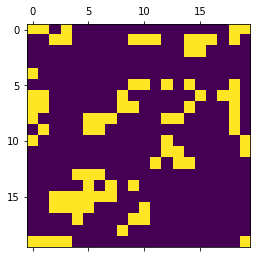

In [ ]:
import numpy as np
import threading
import time
import random
import sys
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
from random import randrange


# n - matrix dimension 
n = 20
# 0 - dead   1 - alive
vals = [0,1]

#State matrix
stateMatrix = np.random.choice(vals,n*n, p = [0.5,0.5]).reshape(n,n)

#Matrica brojaca - polje predstavlja koliko suseda je pristupilo toj celiji, kada broj pristupa = 8 vrsi se update date celije jer joj se nece pristupati do sledece iteracije matrice
counterMatrix = np.full((n,n),8)

#Matrica semafora
neighboursDone = [[threading.Semaphore(0) for i in range(n)] for j in range(n)]

#Globalni niz za animacicju
steps = []

#Dodaj pocetnu sliku matrice
steps.append(stateMatrix.astype(np.int8))

update_counter = 0
update_counter_condition = threading.Condition()

mutex_counter_update = [[threading.Semaphore(1) for i in range(n)] for j in range(n)]
globalUpdate = threading.Lock()


#Pristupi stanju u celiji, dec brojac pristupa za 1
def checkCell(row,col):
  #Zakljucaj mutex[r][c]
  mutex_counter_update[row][col].acquire()

  counterMatrix[row][col] = counterMatrix[row][col] -1

  if(counterMatrix[row][col] == 0):
    neighboursDone[row][col].release()

  mutex_counter_update[row][col].release()
  
  return stateMatrix[row][col]
 

#Inc broj updatovanih celija
def incrementUpdateCounter():
  global update_counter
  global counterMatrix
  global steps
  update_counter_condition.acquire()
  update_counter += 1

  if(update_counter == n*n):
    #Reset counterMatrix, stavi novu sliku matricce za animaciju
    update_counter_condition.notifyAll()
    counterMatrix = np.full((n,n),8)
    update_counter = 0
    steps.append(stateMatrix.astype(np.int8))

  else:
    update_counter_condition.wait()

  update_counter_condition.release()
 

def updateCell(row,col):
  t = checkCell(row, (col - 1) % n)
  t = t + checkCell((row - 1) % n, col)
  t = t + checkCell(row, (col + 1) % n)
  t = t + checkCell((row + 1) %n, col)
  t = t + checkCell((row-1) % n, (col - 1) % n)
  t = t + checkCell((row - 1) % n, (col + 1) % n)
  t = t + checkCell((row + 1) % n, (col - 1) % n)
  t = t + checkCell((row + 1) % n, (col + 1) % n)

  #Novo stanje
  X = int(newState(row,col,t))

  #Uzmi semaphor za trenutnu celiju u matrici
  neighboursDone[row][col].acquire()
  
  stateMatrix[row][col] = X


  incrementUpdateCounter()

def newState(row,col,total):
  global stateMatrix
  x = total
  #Mrtva i ima 3 ziva suseda -> Ziva
  if(stateMatrix[row][col] == 0 and (x == 3)): 
    return 1
  #Ima manje od 2 ziva suseda -> Mrtva
  #Ima 3 ziva suseda -> Mrtva
  if((x < 2) or (x > 3)):
    return 0
  #Ziva i ima 2 ili 3 ziva suseda -> Ziva
  if(stateMatrix[row][col] == 1 and ((x == 2) or (x == 3))):
    return 1
  return 0

def start(steps):
  for x in range(steps):
    ts = []
    for i in range(n):
      for j in range(n):
        ts.append(threading.Thread(target= updateCell, args=(i,j)))
  
    for t in ts:
     t.start()
    for t in ts:
      t.join()


def animate(steps):
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim

start(20)


anim = animate(steps);
HTML(anim.to_html5_video())